<a href="https://colab.research.google.com/github/ritik-hue/deep-learning-projects/blob/main/languageclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import math
import pandas as pd
import collections
from itertools import permutations
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function to easily split data into training and testing samples
from sklearn.decomposition import PCA # Principal component analysis used to reduce the number of features in a model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve,accuracy_score,log_loss
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
df=pd.read_csv('/content/drive/MyDrive/lang_data.csv')
df = df.dropna() # remove null values for the "text" column
df['text'] = df['text'].astype(str) # Convert the column "text" from object to a string in order to operate on it
df['language'] = df['language'].astype(str)

In [13]:
punc = ('!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?")
vowels=['a','e','i','o','u']
# Define a list of double consecutive vowels which are typically found in Dutch and Afrikaans languages
same_consecutive_vowels = ['aa','ee', 'ii', 'oo', 'uu']
consecutive_vowels = [''.join(p) for p in permutations(vowels,2)]
dutch_combos = ['ij']

# Create a pre-defined set of features based on the "text" column in order to allow us to characterize the string
df['word_count'] = df['text'].apply(lambda x : len(x.split()))
df['character_count'] = df['text'].apply(lambda x : len(x.replace(" ","")))
df['word_density'] = df['word_count'] / (df['character_count'] + 1)
df['punc_count'] = df['text'].apply(lambda x : len([a for a in x if a in punc]))
df['v_char_count'] = df['text'].apply(lambda x : len([a for a in x if a.casefold() == 'v']))
df['w_char_count'] = df['text'].apply(lambda x : len([a for a in x if a.casefold() == 'w']))
df['ij_char_count'] = df['text'].apply(lambda x : sum([any(d_c in a for d_c in dutch_combos) for a in x.split()]))
df['num_double_consec_vowels'] = df['text'].apply(lambda x : sum([any(c_v in a for c_v in same_consecutive_vowels) for a in x.split()]))
df['num_consec_vowels'] = df['text'].apply(lambda x : sum([any(c_v in a for c_v in consecutive_vowels) for a in x.split()]))
df['num_vowels'] = df['text'].apply(lambda x : sum([any(v in a for v in vowels) for a in x.split()]))
df['vowel_density'] = df['num_vowels']/df['word_count']
df['capitals'] = df['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['character_count']),axis=1)
df['num_exclamation_marks'] =df['text'].apply(lambda x: x.count('!'))
df['num_question_marks'] = df['text'].apply(lambda x: x.count('?'))
df['num_punctuation'] = df['text'].apply(lambda x: sum(x.count(w) for w in punc))
df['num_unique_words'] = df['text'].apply(lambda x: len(set(w for w in x.split())))
df['num_repeated_words'] = df['text'].apply(lambda x: len([w for w in collections.Counter(x.split()).values() if w > 1]))
df['words_vs_unique'] = df['num_unique_words'] / df['word_count']
df['encode_ascii'] = np.nan
for i in range(len(df)):
    try:
        df['text'].iloc[i].encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        df['encode_ascii'].iloc[i] = 0
    else:
        df['encode_ascii'].iloc[i] = 1

<ipython-input-13-afa385e43185>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encode_ascii'].iloc[i] = 1
<ipython-input-13-afa385e43185>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encode_ascii'].iloc[i] = 0


In [14]:
df.groupby('language').mean().T


<ipython-input-14-0db391084147>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('language').mean().T


language,Afrikaans,English,Nederlands
word_count,10.503912,4.072506,5.746269
character_count,43.541471,16.841849,26.074627
word_density,0.234060,0.226490,0.209378
punc_count,1.507042,0.317275,1.223881
v_char_count,0.652582,0.126521,0.358209
w_char_count,0.904538,0.291971,0.522388
ij_char_count,0.000000,0.000000,0.268657
num_double_consec_vowels,1.696401,0.178589,1.014925
num_consec_vowels,2.773083,0.536253,1.134328
num_vowels,9.114241,3.742579,5.671642


In [15]:
df.corr(method ='pearson')


<ipython-input-15-65d33cd9412f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method ='pearson')


,word_count,character_count,word_density,punc_count,v_char_count,w_char_count,ij_char_count,num_double_consec_vowels,num_consec_vowels,num_vowels,vowel_density,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_unique_words,num_repeated_words,words_vs_unique,encode_ascii
word_count,1.000000,0.963818,0.284142,0.656144,0.499937,0.576566,0.002617,0.714460,0.769932,0.985911,-0.158172,0.408048,-0.449626,0.161356,0.054530,0.656144,0.985286,0.785662,-0.609634,-0.500432
character_count,0.963818,1.000000,0.066516,0.685772,0.535066,0.579176,0.012066,0.737948,0.801404,0.960918,-0.089117,0.409393,-0.486624,0.174488,0.065903,0.685772,0.950250,0.751124,-0.570829,-0.506098
word_density,0.284142,0.066516,1.000000,0.001107,0.002239,0.061311,-0.032624,0.050620,0.042554,0.249241,-0.356830,0.081018,0.062398,-0.011030,0.001162,0.001107,0.306803,0.143736,-0.178659,-0.077037
punc_count,0.656144,0.685772,0.001107,1.000000,0.370564,0.374964,0.042030,0.548477,0.563451,0.621920,-0.228459,0.385474,-0.287332,0.205043,0.119390,1.000000,0.652952,0.487491,-0.379424,-0.392489
v_char_count,0.499937,0.535066,0.002239,0.370564,1.000000,0.233034,0.022992,0.389565,0.424615,0.499093,-0.038331,0.250590,-0.249199,0.095870,0.025231,0.370564,0.502898,0.367544,-0.287014,-0.337758
w_char_count,0.576566,0.579176,0.061311,0.374964,0.233034,1.000000,0.005225,0.468219,0.413632,0.580779,-0.002004,0.204286,-0.280512,0.111205,0.101982,0.374964,0.562223,0.464511,-0.353433,-0.298730
ij_char_count,0.002617,0.012066,-0.032624,0.042030,0.022992,0.005225,1.000000,0.000365,-0.010899,0.012548,0.047971,-0.021422,-0.048555,-0.007353,-0.007675,0.042030,0.007278,-0.016064,0.017089,0.023861
num_double_consec_vowels,0.714460,0.737948,0.050620,0.548477,0.389565,0.468219,0.000365,1.000000,0.588212,0.707235,-0.079424,0.245026,-0.352140,0.174573,0.040402,0.548477,0.705972,0.563045,-0.412084,-0.471362
num_consec_vowels,0.769932,0.801404,0.042554,0.563451,0.424615,0.413632,-0.010899,0.588212,1.000000,0.776344,-0.044574,0.286679,-0.401469,0.121268,0.033055,0.563451,0.759246,0.604320,-0.452598,-0.436547
num_vowels,0.985911,0.960918,0.249241,0.621920,0.499093,0.580779,0.012548,0.707235,0.776344,1.000000,-0.022570,0.357889,-0.480243,0.158128,0.057858,0.621920,0.968959,0.782950,-0.614507,-0.450493


In [16]:
feature_cols = list(df.columns)[2:]
X = df[feature_cols] # Features
y = df[['language']] # Target variable
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Transform both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Make an instance of the model to retain 95% of the variance within the old features.
pca = PCA(.95)
pca.fit(X_train)

print('Number of Principal Components = '+str(pca.n_components_))
# Number of Principal Components = 13

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

Number of Principal Components = 13


In [18]:
rf_clf = RandomForestClassifier(n_estimators=100) # Create Random Forest classifer object
rf_clf = rf_clf.fit(X_train,y_train) # Fit/Train Random Forest Classifer on training set

# Save model to file in the current working directory so that it can be imported and used.
pkl_file = "random_forest_model.pkl"
with open(pkl_file, 'wb') as file:
    pickle.dump(rf_clf, file)

# Load previously trained model from pickle file
with open(pkl_file, 'rb') as file:
    rf_clf = pickle.load(file)
rf_clf

y_pred = rf_clf.predict(X_test)

<ipython-input-18-d1ed171815fe>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf = rf_clf.fit(X_train,y_train) # Fit/Train Random Forest Classifer on training set


Accuracy of the Random Forest Model on the test set = 89.51%


Text(0.5, 1.0, 'Random Forest Model Accuracy Score = 89.51%')

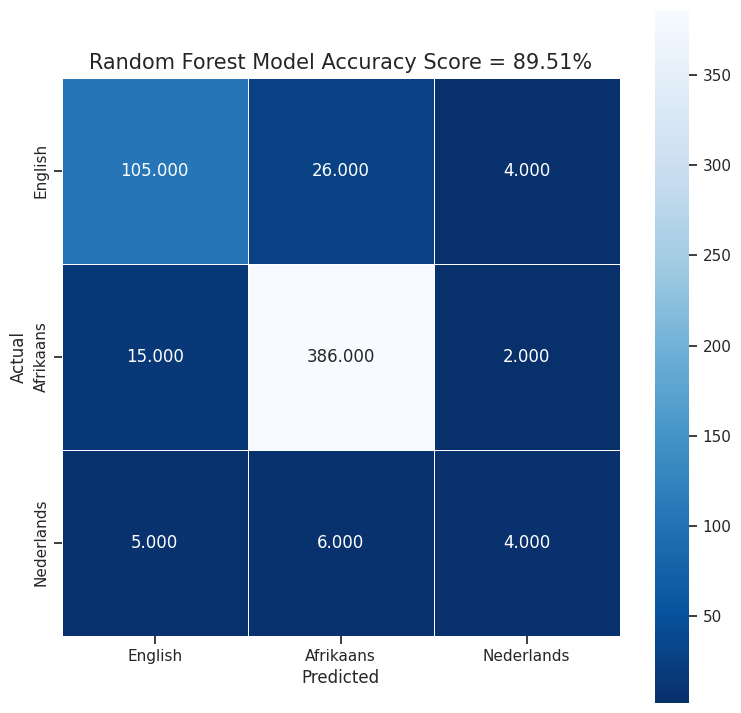

In [21]:
accuracy_score_rf = accuracy_score(y_test, y_pred)
print('Accuracy of the Random Forest Model on the test set = ' + str(round(accuracy_score_rf*100,2)) +"%" )

labels = ['English', 'Afrikaans', 'Nederlands']
# Confusion Matrix is often used to describe the performance of a classification model
cm_Model_rf = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
sns.heatmap(cm_Model_rf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
title = 'Random Forest Model Accuracy Score = '+ str(round(accuracy_score_rf*100,2)) +"%"
plt.title(title, size = 15)

In [19]:
learning_rate = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for lr in learning_rate:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=lr)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", lr)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (testing): {0:.3f}".format(gb_clf.score(X_test, y_test)))
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=1)
gb_clf.fit(X_train, y_train)

# Save model to file in the current working directory so that it can be imported and used.
# I use the pickle library to save the parameters of the trained model
pkl_file = "gradient_boost_model.pkl"
with open(pkl_file, 'wb') as file:
    pickle.dump(gb_clf, file)

# Load previously trained model from pickle file
with open(pkl_file, 'rb') as file:
    gb_clf = pickle.load(file)

gb_clf # parameters of the Gradient Boost model are shown below

y_pred = gb_clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.05
Accuracy score (training): 0.907
Accuracy score (testing): 0.893


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.075
Accuracy score (training): 0.918
Accuracy score (testing): 0.899


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.1
Accuracy score (training): 0.927
Accuracy score (testing): 0.910


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.25
Accuracy score (training): 0.960
Accuracy score (testing): 0.910


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.5
Accuracy score (training): 0.979
Accuracy score (testing): 0.910


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.75
Accuracy score (training): 0.986
Accuracy score (testing): 0.908


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  1
Accuracy score (training): 0.992
Accuracy score (testing): 0.890


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
